# Principal components analysis for order parameter construction

In [677]:
from analysis_tools.read_traj import ReadTraj
from analysis_tools.feature_creation import FrameToFeaturesPosition, TrajectoryToFeaturesPosition
from analysis_tools.feature_creation import FrameToFeaturesComposition, TrajectoryToFeaturesComposition
from analysis_tools.radial_distribution_function import RDF, PositionalSuceptibility
from analysis_tools.reservoir_sampler import ReservoirSampler
from analysis_tools.defect_analysis import DefectStats
import gc
from IPython.display import clear_output

In [393]:
def DownSampleFrames(frames, frame_samples):
    return frames[0::max(len(frames)/frame_samples, 1)][0:frame_samples]

In [297]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [298]:
%autoreload 2

---

## Models

In [299]:
from numpy import array, arange

### Model data

#### Hard disks

In [639]:
N_nn = 3200 #number of nearest neighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
nn_inc = 32 #reduces the number of nearest neighbors to include as features
remove_types = []
shuffle_data = True
N_batch = 10
batches_per_frame = 10 #10 #5

In [678]:
#VERSION FOR PAPER I
N_nn = 3200 #number of nearest neighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
nn_inc = 1 #1 (full in paper) #reduces the number of nearest neighbors to include as features
remove_types = []
shuffle_data = True
N_batch = 1
batches_per_frame = 50 #10 #5

In [554]:
#TEST
N_nn = 3200 #number of nearest neighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
nn_inc = 100 #1 (full in paper) #reduces the number of nearest neighbors to include as features
remove_types = []
shuffle_data = True
N_batch = 40
batches_per_frame = 8 #10 #5

In [566]:
#specify what data to read in and process
traj_type = 'gsd'
file_data = [(arange(0.550, 0.690001, 0.005), '../hoomd_disks/trajectories_4000p', 100000), 
             (arange(0.695, 0.820001, 0.005),'../hoomd_disks/trajectories_4000p_longer', 100000)]

#### Hard spheres

In [206]:
N_nn = 2100 #number of nearest nighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
nn_inc = 1 #reduces the number of nearest neighbors to include as features
remove_types = []
shuffle_data = True
N_batch = 1
batches_per_frame = 50

In [205]:
#specify what data to read in and process
traj_type = 'gsd'
file_data = [(arange(0.400, 0.695001, 0.005), '../hoomd_spheres/trajectories_4000p', 1000000)]

Branches

In [303]:
N_nn = 2100 #number of nearest nighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
nn_inc = 1 #reduces the number of nearest neighbors to include as features
remove_types = []
shuffle_data = True
N_batch = 1
batches_per_frame = 200

In [382]:
#actual data for training and modeling
traj_type = 'gsd'
file_data = [(arange(0.400, 0.525001, 0.005), '../hoomd_spheres/trajectories_4000p', 200), 
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_1/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_2/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_3/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_4/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_5/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_6/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_7/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_8/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_9/trajectories/', 20),
             (arange(0.530, 0.690001, 0.005), '../hoomd_spheres/trajectories_4000p/quench_10/trajectories/', 20)]

#any reference data for comparison
ref_traj_type = 'xyz'
ref_file_data = [(arange(0.7405, 0.740501, 0.005), '../hoomd_spheres/trajectories_4000p/fcc_reference', 1)]

#### Widom-Rowlinson

In [455]:
N_nn = 50 #number of nearest nighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
####particle_inc = 200 #skip this many particles in generating features
nn_inc = 1 #reduces the number of nearest neighbors to include as features
####method = ['distance']
remove_types = []# ['B']
shuffle_data = True
N_batch = 10
batches_per_frame = 1

In [4]:
#specify what data to read in and process
traj_type = 'gsd'
file_data = [(arange(0.100, 2.06001, 0.04), '../hoomd_disks/trajectories_ww_4000p')]

In [5]:
#specify what data to read in and process
traj_type = 'gsd'
file_data = [(arange(0.100, 3.50001, 0.04), '../hoomd_disks/trajectories_ww_4000p_0.25')]

### Density range and color ids for plotting

In [679]:
#actual data
etas = []
[etas.extend(etas_) for etas_, _, _ in file_data]
etas = array(etas)
color_ids = []
[color_ids.extend(len(data[0])*[count]) for count, data in zip(range(len(file_data)), file_data)]
color_ids = array(color_ids)

In [519]:
#reference data
ref_etas = []
[ref_etas.extend(etas_) for etas_, _, _ in ref_file_data]
ref_etas = array(ref_etas)
ref_color_ids = []
[ref_color_ids.extend(len(data[0])*[count]) for count, data in zip(range(len(ref_file_data)), ref_file_data)]
ref_color_ids = array(ref_color_ids)

---

## Perfom PCA

In [240]:
from numpy import array_split
from sklearn.decomposition import IncrementalPCA

### Train on ideal gas structure first to identify trivial variance contributions

The purpose is to transform the features into new features that are uncorrelated and of equal variance when applied to the ideal gas

This is not always useful as some features naturally will obey this ideal gas limit, though there is no harm to do it other than computational cost

The rationale for this is twofold:
1. Intuitively, there should be nothing to "learn" from the ideal (this is the maximally random disordered state)
2. Practically speaking, performing this yields a cleaned up eigenvalue spectrum, zeroing in on the actually relevent order parameters and not trivial order parameters that describe ideal gas correlations trivially induced by feature construction

<img src="./supplemental_files/whitening.jpg" style="float: left;" width="900">

In [680]:
raw_OPs = []
ref_raw_OPs = []

In [681]:
##########MODE###########
mode = 'model_data_w_ig'
#########################

if mode == 'model_data_w_ig':
    incpca_ig = IncrementalPCA(n_components=None, whiten=True)  #whitening is ON
    incpca = IncrementalPCA(n_components=None, whiten=False)  #whitening is OFF
    __phases__ = ['fit_whitener', 'fit_model', 'compute_ops']
    __raw_OPs__ = raw_OPs
    __file_data__ = file_data
    __traj_type__ = traj_type
elif mode == 'model_data_wo_ig':
    incpca_ig = IncrementalPCA(n_components=None, whiten=True)  #whitening is ON
    incpca = IncrementalPCA(n_components=None, whiten=False)  #whitening is OFF
    __phases__ = ['fit_model', 'compute_ops']
    __raw_OPs__ = raw_OPs
    __file_data__ = file_data
    __traj_type__ = traj_type    

#elif mode == 'ref_data':
#    __phases__ = ['compute_ops']
#    __raw_OPs__ = ref_raw_OPs
#    __file_data__ = ref_file_data
#    __traj_type__ = ref_traj_type

In [682]:
from numpy import abs, power, mean

In [683]:
OPs = []
OPs_sq = []
OPs_abs = []

In [684]:
force_randomize = False
reservoir_sampler = ReservoirSampler(0)
minimum_samples = 200

In [ ]:
#intermediate variables
frames = None
features = None

#for controlling the status printing
print_count = 1
max_print = 2

#perform all of the modeling phases in one fell swoop
for phase in __phases__:
    
    #loop over data sets 
    for etas_, file_base, frame_samples in __file_data__: #file_data:

        #loop over statepoints within a given data set
        for eta in etas_:
            print 'COMPUTATION DETAILS'
            print 'phase = {}'.format(phase)
            print 'file_base = {}'.format(file_base)
            print 'eta = {}'.format(eta)
            
            #read in data and randomize positions if performing ideal gas correction
            filename = "{}/trajectory_{:.4f}.{}".format(file_base, eta, __traj_type__)
            randomize = (phase == 'fit_whitener') or force_randomize
            frames = ReadTraj(filename, __traj_type__, shuffle_data, randomize, remove_types)
            
            #control the number of total frames to analyze
            len_frames_init = len(frames)
            frames = DownSampleFrames(frames, frame_samples)
            print 'using {} frames of {} total'.format(len(frames), len_frames_init)
            
            #split the frames for memory purposes
            frames_split = array_split(frames, split)
            frames = None
            
            #loop over the split data for memory management
            OPs_single = []
            OPs_sq_single = []
            OPs_abs_single = []
            for frames_partial in frames_split:
                features_partial = TrajectoryToFeaturesPosition(frames_partial, 
                                                                N_nn=N_nn,  
                                                                nn_inc=nn_inc,
                                                                N_batch=N_batch, 
                                                                batches_per_frame=batches_per_frame)
                
                #free up some memory
                frames_partial = None

                #check that n_rows > n_columns as this is neccesary for accuracy and the ideal gas transformation to be valid
                if features_partial.shape[0] < features_partial.shape[1] and phase in ['fit_whitener', 'fit_model']:
                    raise Exception('The partial feature set has less rows than columns!')
                print 'partial feature shape = {}'.format(features_partial.shape)

                #perform the various model phases
                if phase == 'fit_whitener': 
                    incpca_ig.partial_fit(features_partial)
                elif phase == 'fit_model':
                    try:
                        features_partial = incpca_ig.transform(features_partial)
                    except:
                        None
                    incpca.partial_fit(features_partial)
                    #reservoir_sampler.NewSamples(features_partial[:,0:10])  ###store a few examples
                    gc.collect()
                elif phase == 'compute_ops' :
                    try:
                        features_partial = incpca_ig.transform(features_partial)
                    except:
                        None
                    transformed_features_partial = incpca.transform(features_partial)
                    OPs_single.append(mean(transformed_features_partial, axis=0))
                    OPs_sq_single.append(mean(power(transformed_features_partial, 2), axis=0))
                    OPs_abs_single.append(mean(abs(transformed_features_partial), axis=0))
                
                #free up some memory
                features_partial = None

            #print control
            print '\n'
            if print_count % max_print == 0:
                clear_output()
            print_count+=1

            if phase == 'compute_ops': 
                OPs.append(mean(OPs_single, axis=0))
                OPs_sq.append(mean(OPs_sq_single, axis=0))
                OPs_abs.append(mean(OPs_abs_single, axis=0))

COMPUTATION DETAILS
phase = fit_whitener
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.55
using 1000 frames of 1000 total
partial feature shape = (50000, 3200)


COMPUTATION DETAILS
phase = fit_whitener
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.555
using 1000 frames of 1000 total
partial feature shape = (50000, 3200)


## Perfom defect analysis

In [ ]:
num_frames = 1000
defects = []
for etas_, file_base, frame_samples in __file_data__: 
    for eta in etas_:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.{}".format(file_base, eta, __traj_type__)
        frames = ReadTraj(filename, __traj_type__, shuffle_data, False, remove_types)
        
        #control the number of total frames to analyze
        len_frames_init = len(frames)
        frames = DownSampleFrames(frames, num_frames)
        print 'using {} frames of {} total'.format(len(frames), len_frames_init)
        
        defects.append(DefectStats(frames))
        
defects = array(defects)

eta=0.55

using 1000 frames of 1000 total
eta=0.555

using 1000 frames of 1000 total
eta=0.56

using 1000 frames of 1000 total
eta=0.565

using 1000 frames of 1000 total
eta=0.57

using 1000 frames of 1000 total
eta=0.575

using 1000 frames of 1000 total
eta=0.58

using 1000 frames of 1000 total
eta=0.585

using 1000 frames of 1000 total
eta=0.59

using 1000 frames of 1000 total
eta=0.595

using 1000 frames of 1000 total
eta=0.6

using 1000 frames of 1000 total
eta=0.605

using 1000 frames of 1000 total
eta=0.61

using 1000 frames of 1000 total
eta=0.615

using 1000 frames of 1000 total
eta=0.62

using 1000 frames of 1000 total
eta=0.805

using 1000 frames of 1000 total
eta=0.81

using 1000 frames of 1000 total
eta=0.815

using 1000 frames of 1000 total
eta=0.82

using 1000 frames of 1000 total


## Perfom man-made order parameter analysis

In [374]:
num_frames = 20
dr = 0.05

pos_spt = []
for etas_, file_base, frame_samples in __file_data__: 
    for eta in etas_:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.{}".format(file_base, eta, __traj_type__)
        frames = ReadTraj(filename, __traj_type__, shuffle_data, False, remove_types)
        
        #control the number of total frames to analyze
        len_frames_init = len(frames)
        frames = DownSampleFrames(frames, num_frames)
        print 'using {} frames of {} total'.format(len(frames), len_frames_init)
        
        #calculate the suscept and store rdfs too
        ps, r, gr = PositionalSuceptibility(frames, dr)
        pos_spt.append(ps)
        
pos_spt = array(pos_spt)

eta=0.4

using 20 frames of 1000 total
eta=0.405

using 20 frames of 1000 total
eta=0.41

using 20 frames of 1000 total
eta=0.415

using 20 frames of 1000 total
eta=0.42

using 20 frames of 1000 total
eta=0.425

using 20 frames of 1000 total
eta=0.43

using 20 frames of 1000 total
eta=0.435

using 20 frames of 1000 total
eta=0.44

using 20 frames of 1000 total
eta=0.445

using 20 frames of 1000 total
eta=0.45

using 20 frames of 1000 total
eta=0.455

using 20 frames of 1000 total
eta=0.46

using 20 frames of 1000 total
eta=0.465

using 20 frames of 1000 total
eta=0.47

using 20 frames of 1000 total
eta=0.475

using 20 frames of 1000 total
eta=0.48

using 20 frames of 1000 total
eta=0.485

using 20 frames of 1000 total
eta=0.49

using 20 frames of 1000 total
eta=0.495

using 20 frames of 1000 total
eta=0.5

using 20 frames of 1000 total
eta=0.505

using 20 frames of 1000 total
eta=0.51

using 20 frames of 1000 total
eta=0.515

using 20 frames of 1000 total
eta=0.52

using 20 frames of 1

eta=0.635

using 20 frames of 20 total
eta=0.64

using 20 frames of 20 total
eta=0.645

using 20 frames of 20 total
eta=0.65

using 20 frames of 20 total
eta=0.655

using 20 frames of 20 total
eta=0.66

using 20 frames of 20 total
eta=0.665

using 20 frames of 20 total
eta=0.67

using 20 frames of 20 total
eta=0.675

using 20 frames of 20 total
eta=0.68

using 20 frames of 20 total
eta=0.685

using 20 frames of 20 total
eta=0.69

using 20 frames of 20 total
eta=0.53

using 20 frames of 20 total
eta=0.535

using 20 frames of 20 total
eta=0.54

using 20 frames of 20 total
eta=0.545

using 20 frames of 20 total
eta=0.55

using 20 frames of 20 total
eta=0.555

using 20 frames of 20 total
eta=0.56

using 20 frames of 20 total
eta=0.565

using 20 frames of 20 total
eta=0.57

using 20 frames of 20 total
eta=0.575

using 20 frames of 20 total
eta=0.58

using 20 frames of 20 total
eta=0.585

using 20 frames of 20 total
eta=0.59

using 20 frames of 20 total
eta=0.595

using 20 frames of 20 total

In [650]:
from numpy import power, sqrt, abs

In [651]:
OPs = array(OPs)
OPs_sq = array(OPs_sq)
OPs_abs = array(OPs_abs)
OPs_std = sqrt(OPs_sq-power(OPs, 2))

** Save the data **

In [77]:
from numpy import savetxt, concatenate, transpose, dot

Hard disks without whitening

In [460]:
#data_folder = 'hd_wo_ig'
#num_dim = 10
#savetxt('./processed_data/{}/OPs.csv'.format(data_folder), concatenate((transpose(array([etas])), OPs[:,0:num_dim]), axis=1))
#savetxt('./processed_data/{}/comps.csv'.format(data_folder), transpose(incpca.components_)[:,0:num_dim])
#savetxt('./processed_data/{}/exp_var.csv'.format(data_folder), transpose(incpca.explained_variance_ratio_))

Ideal gas without whitening

In [41]:
#data_folder = 'ig_wo_ig'
#num_dim = 10
#savetxt('./processed_data/{}/OPs.csv'.format(data_folder), concatenate((transpose(array([etas])), OPs[:,0:num_dim]), axis=1))
#savetxt('./processed_data/{}/comps.csv'.format(data_folder), transpose(incpca.components_)[:,0:num_dim])
#savetxt('./processed_data/{}/exp_var.csv'.format(data_folder), transpose(incpca.explained_variance_ratio_))

#sampled_features = array(reservoir_sampler.ReturnReservoir())
#savetxt('./processed_data/{}/sampled_features.csv'.format(data_folder), sampled_features)


Hard disks with whitening

In [78]:
#data_folder = 'hd_w_ig'
#num_dim = 10
#savetxt('./processed_data/{}/OPs.csv'.format(data_folder), concatenate((transpose(array([etas])), OPs[:,0:num_dim]), axis=1))
#savetxt('./processed_data/{}/comps.csv'.format(data_folder), transpose(dot(incpca.components_, incpca_ig.components_))[:,0:num_dim])
#savetxt('./processed_data/{}/exp_var.csv'.format(data_folder), transpose(incpca.explained_variance_ratio_))

#sampled_features = array(reservoir_sampler.ReturnReservoir())
#savetxt('./processed_data/{}/sampled_features.csv'.format(data_folder), sampled_features)

Hard disks with whitening (skip 10 particles)

In [430]:
#data_folder = 'hd_w_ig_skip_10'
#num_dim = 10
#savetxt('./processed_data/{}/OPs.csv'.format(data_folder), concatenate((transpose(array([etas])), OPs[:,0:num_dim]), axis=1))
#savetxt('./processed_data/{}/comps.csv'.format(data_folder), transpose(dot(incpca.components_, incpca_ig.components_))[:,0:num_dim])
#savetxt('./processed_data/{}/exp_var.csv'.format(data_folder), transpose(incpca.explained_variance_ratio_))

#sampled_features = array(reservoir_sampler.ReturnReservoir())
#savetxt('./processed_data/{}/sampled_features.csv'.format(data_folder), sampled_features)

Hard disks with whitening (skip 100 particles)

In [474]:
data_folder = 'hd_w_ig_skip_100'
num_dim = 10
savetxt('./processed_data/{}/OPs.csv'.format(data_folder), concatenate((transpose(array([etas])), OPs[:,0:num_dim]), axis=1))
savetxt('./processed_data/{}/comps.csv'.format(data_folder), transpose(dot(incpca.components_, incpca_ig.components_))[:,0:num_dim])
savetxt('./processed_data/{}/exp_var.csv'.format(data_folder), transpose(incpca.explained_variance_ratio_))

sampled_features = array(reservoir_sampler.ReturnReservoir())
savetxt('./processed_data/{}/sampled_features.csv'.format(data_folder), sampled_features)

Ideal gas with whitening

In [63]:
#data_folder = 'ig_w_ig'
#num_dim = 10
#savetxt('./processed_data/{}/OPs.csv'.format(data_folder), concatenate((transpose(array([etas])), OPs[:,0:num_dim]), axis=1))
#savetxt('./processed_data/{}/comps.csv'.format(data_folder), transpose(incpca.components_)[:,0:num_dim])
#savetxt('./processed_data/{}/exp_var.csv'.format(data_folder), transpose(incpca.explained_variance_ratio_))

#sampled_features = array(reservoir_sampler.ReturnReservoir())
#savetxt('./processed_data/{}/sampled_features.csv'.format(data_folder), sampled_features)

Hard disk defect analysis

In [128]:
#data_folder = 'hd_defects'
#savetxt('./processed_data/{}/defects.csv'.format(data_folder), concatenate((transpose(array([etas])), defects), axis=1))

Hard disk man made order parameter

In [148]:
#data_folder = 'hd_pos_spt'
#savetxt('./processed_data/{}/pos_spt.csv'.format(data_folder), concatenate((transpose(array([etas])), transpose(array([pos_spt]))), axis=1))

Hard spheres with whitening

In [193]:
#data_folder = 'hs_w_ig'
#num_dim = 10
#savetxt('./processed_data/{}/OPs.csv'.format(data_folder), concatenate((transpose(array([etas])), OPs[:,0:num_dim]), axis=1))
#savetxt('./processed_data/{}/comps.csv'.format(data_folder), transpose(dot(incpca.components_, incpca_ig.components_))[:,0:num_dim])
#savetxt('./processed_data/{}/exp_var.csv'.format(data_folder), transpose(incpca.explained_variance_ratio_))

Hard sphere branches

In [366]:
#data_folder = 'hs_branches_w_ig'
#num_dim = 10

#for i in range(len(etas_by_id)):
#    savetxt('./processed_data/{}/OPs_{}.csv'.format(data_folder, i), concatenate((transpose(array([etas_by_id[i]])), OPs_by_id[i][:,0:num_dim]), axis=1))

#    savetxt('./processed_data/{}/comps.csv'.format(data_folder), transpose(dot(incpca.components_, incpca_ig.components_))[:,0:num_dim])
#savetxt('./processed_data/{}/exp_var.csv'.format(data_folder), transpose(incpca.explained_variance_ratio_))



---

### Compute order parameter stats

In [491]:
from numpy import array, mean, std, abs

In [314]:
OPs = []
OPs_std = []
OPs_abs = []

for single_eta in raw_OPs:
    merged_data = []
    for entry in single_eta:
        merged_data.extend(entry)

    OPs.append(mean(merged_data, axis=0))
    OPs_std.append(std(merged_data, axis=0))
    OPs_abs.append(mean(abs(merged_data), axis=0))
    
OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)

In [285]:
from numpy import unique

In [334]:
OPs_by_id = []
etas_by_id = []

for num in unique(color_ids):
    OPs_by_id.append(OPs[color_ids == num])
    etas_by_id.append(etas[color_ids == num])
    
OPs_by_id = array(OPs_by_id)
etas_by_id = array(etas_by_id)

In [152]:
ref_OPs = []
ref_OPs_std = []
ref_OPs_abs = []

for single_eta in ref_raw_OPs:
    merged_data = []
    for entry in single_eta:
        merged_data.extend(entry)

    ref_OPs.append(mean(merged_data, axis=0))
    ref_OPs_std.append(std(merged_data, axis=0))
    ref_OPs_abs.append(mean(abs(merged_data), axis=0))
    
ref_OPs = array(ref_OPs)
ref_OPs_std = array(ref_OPs_std)
ref_OPs_abs = array(ref_OPs_abs)

In [320]:
incpca_ig

IncrementalPCA(batch_size=None, copy=True, n_components=None, whiten=True)

In [316]:
OPs

array([], dtype=float64)

---

## Check out the results of PCA

In [652]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

### Explained variance from ideal gas fit

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if __name__ == '__main__':


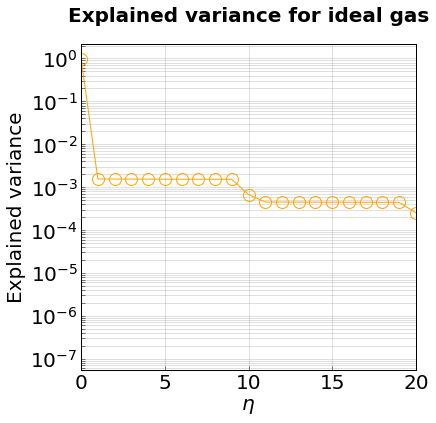

In [654]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca_ig.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'orange', markerfacecolor='None')  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.yscale('log')
plt.xlim(0,20)

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Explained variance for ideal gas', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


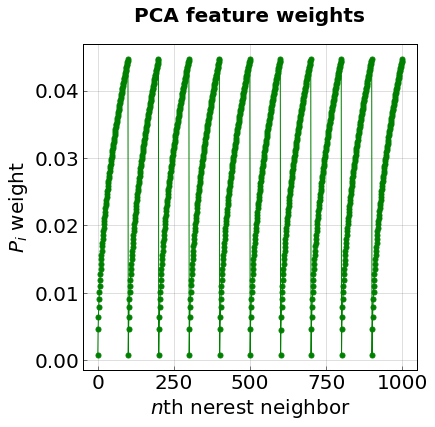

In [655]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1):
    p_data = incpca_ig.components_[i]
    plt.plot(range(len(p_data)), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i])  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.1,100)
#plt.ylim(-0.001,0.001)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.yscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

### Explained variance from full model

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


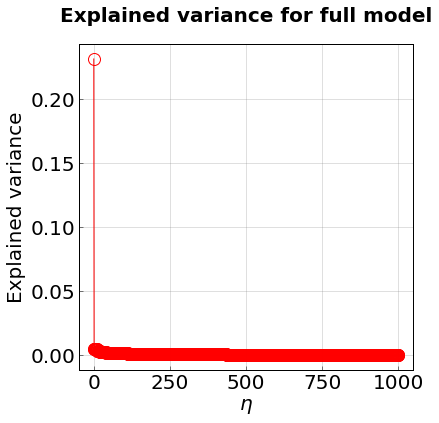

In [656]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'red', markerfacecolor='None')  
#plt.plot(incpca_ig.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'orange', markerfacecolor='None')  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.xlim(-1,40)
#plt.ylim(0.003,0.4)
#plt.xscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Explained variance for full model', y=1.05, fontdict = title_font)

plt.show()

### Principal component weights

Since the data is generally a result of two nested models the "true" intuitive feature weights are a matrix product of the two model component matrices

In [657]:
from numpy import dot

In [658]:
components = dot(incpca.components_, incpca_ig.components_)

12
36
72
120
180
252
336
432


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


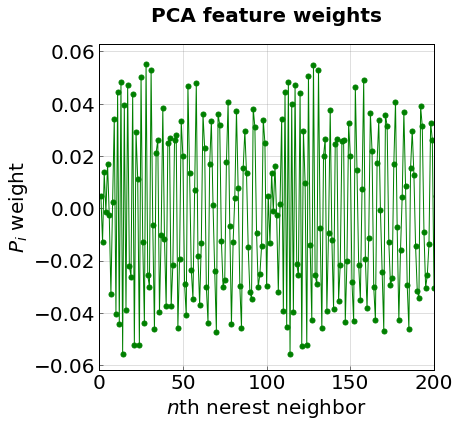

In [659]:
j = 0
for i in arange(12,100,12):
    j = j + i
    #plt.axvline(x=j, color='r', linestyle='--')
    print j
#plt.axvline(x=90, color='b', linestyle='--')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1):
    p_data = components[i]
    plt.plot(1+array(range(len(p_data))), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i])  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(0,200)
#plt.ylim(-0.001,0.001)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.xscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

### Order parameters

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


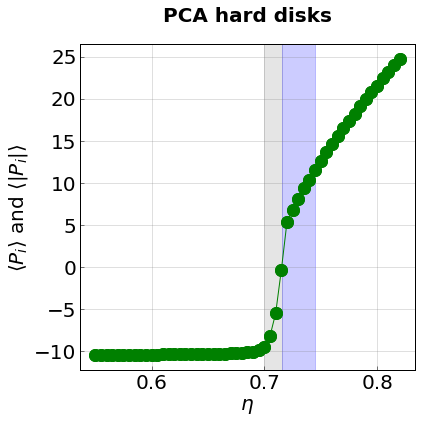

In [661]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 0.0, markersize=12, color = colors[i], markerfacecolor='None')
    #p_data = OPs_10_100[:,i]
    #plt.plot(etas, -(p_data), marker='o', linewidth = 0.0, markersize=4, color = colors[i], markerfacecolor='green')
    #p_data = OPs_abs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])
#plt.plot(etas[1:], -(OPs[:,0][1:]-OPs[:,0][:-1])/(etas[1]-etas[0]), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.4, 0.9069)
#plt.ylim(1,3)

#plt.ylim(-7,5)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


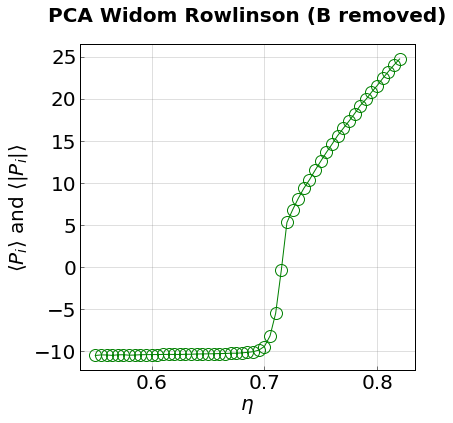

In [662]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = OPs_std[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA Widom Rowlinson (B removed)', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  app.launch_new_instance()


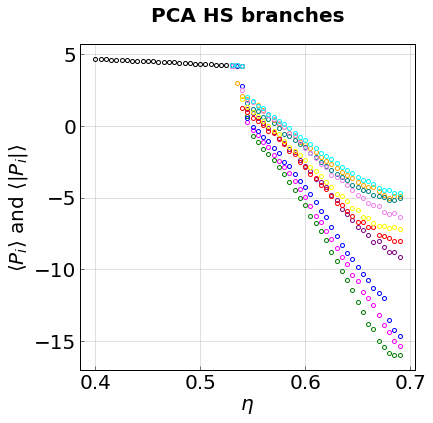

In [372]:
op = 0

#plt.axhline(y=ref_OPs[:,op], color='r', linestyle='-')

colors = 200*['black', 'purple', 'orange', 'teal', 'green', 'red', 'yellow', 'magenta', 'blue', 'violet', 'cyan']
for i in range(len(OPs_by_id)):
    etas = etas_by_id[i]
    op_data = OPs_by_id[i][:,op]
    plt.plot(etas, op_data, marker='o', linewidth = 0.0, markersize=4, color=colors[i], markerfacecolor='None')
    
#plt.plot(ref_etas, ref_OPs[:,op], marker='o', linewidth = 0.0, markersize=4, color=colors[i], markerfacecolor='None')

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.525, 0.56)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA HS branches', y=1.05, fontdict = title_font)

plt.show()

# THE END FOR NOW

## Write out order parameters

In [675]:
file_name = 'trajectory_0.8000'
file_type = 'gsd'
directory = '../hoomd_disks/trajectories_4000p/'
full_file_name = '{}{}.{}'.format(directory, file_name, file_type)
frames = ReadTraj(full_file_name, file_type, False, False, [])
max_frames = 20

### PCs

In [418]:
pc = 0

xyz_file_stream = open('op_labeled/P{}__{}__.xyz'.format(pc, file_name), 'w')
for frame in frames[0:max_frames]:
    coords = frame['coords']
    N = len(coords)
    L = frame['L']
    types = frame['types']
    
    #transform the data to features
    features = FrameToFeaturesPosition(frame, 
                                       N_nn=N_nn,  
                                       nn_inc=nn_inc,
                                       N_batch=1, 
                                       batches_per_frame=4096)
    ops = incpca.transform(incpca_ig.transform(features))[:,pc]
    
    #create header
    xyz_file_stream.write('{}\n'.format(N))
    xyz_file_stream.write(' L={}\n'.format(L))
    
    #joint data
    coords_ops_types = zip(coords, ops, types)
    for coord, op, type_ in coords_ops_types:
        xyz_file_stream.write('  {}    {}    {}    {}\n'.format(type_, coord[0], coord[1], op))
        
xyz_file_stream.close()

### BOPs

In [671]:
from numpy import arctan, rint
from numpy.linalg import norm
import pyvoro

In [676]:
xyz_file_stream = open('op_labeled/BOP__{}__.xyz'.format(file_name), 'w')
for frame in frames[0:max_frames]:
    voro = pyvoro.compute_2d_voronoi(
                                    frame['coords'], # point positions
                                    [[0.0, frame['L']], [0.0, frame['L']]], # limits
                                    4.0, # block size
                                    periodic=[True, True]
                                    )
    voro = array(voro)
        
    #write xyz header
    xyz_file_stream.write('{}\n'.format(len(coords)))
    xyz_file_stream.write(' L={}\n'.format(frame['L']))
    
    #loop over the cells and use nearest neighbor details to calculate BOP
    for i in range(len(voro)):
        ri = voro[i]['original']
        nbrs = voro[i]['faces']
        n = len(nbrs)
        R, I = 0.0, 0.0
        for nbr in nbrs:
            j = nbr['adjacent_cell']
            rj = voro[j]['original']
            rij = ri - rj
            rij = rij - rint(rij/frame['L'])*frame['L']
            c = rij[0]/norm(rij)
            s = rij[1]/norm(rij)
            Rl = (c**6) - 15.0*(c**4)*(s**2) + 15.0*(c**2)*(s**4) - (s**6)
            Il = 6.0*(c**5)*s - 20.0*(c**3)*(s**3) + 6.0*c*(s**5)
            R = R + Rl
            I = I + Il
        R = R/float(n)
        I = I/float(n)
        magnitude = sqrt(R*R + I*I)
        phase = arctan(I/R)
        
        #write coordinate data
        xyz_file_stream.write('  A    {}    {}    0.0    {}    {}    {}    {}\n'.format(ri[0], ri[1], R, I, magnitude, phase))
    
#close out the filestream
xyz_file_stream.close()

## Testing WR mixture

In [88]:
from scipy.special import j0
from numpy import histogram, pi, power, rint
from numpy.linalg import norm
from numpy import trapz

#function for calculating the rdf
def RDF2D(frames, dr):
    M = len(frames)
    N = float(len(frames[0]['coords']))
    L = frames[0]['L']
    rho = float((N-1))/power(L, 2)
    r_edg = arange(0.0, L/2.0, dr)
    r = (r_edg[:-1] + r_edg[1:])/2.0
    hist = 0.0*r
    
    #loop over the frames
    for frame in frames:
        coords = frame['coords']

        #loop over each particle
        for coord in coords:
            #nearest neighbor coordinate wrapping
            Rpj = coord - coords
            Rpj = Rpj - rint(Rpj/L)*L
            Rpj = norm(Rpj, axis=1)
            
            #calculate the histogram
            hist = hist + histogram(Rpj, bins=r_edg)[0]
    
    #normalize out the number of frames and 
    hist = hist/float(M*(N-1))
    gr = hist/((2.0*pi*r*dr)*rho)
    
    return r, gr

#function for calculating the integral of h(r)
def PositionalSuceptibility2D(frames, dr, k):
    N = float(len(frames[0]['coords']))
    L = frames[0]['L']
    rho = float(N)/power(L, 2)
    
    d = float(L)/rint(L)
    k = 2.0*pi/d
    
    #compute the rdfs and calculate S(k0)
    r, gr = RDF2D(frames, dr)
    #Sk0 = 1.0 + 2.0*pi*rho*trapz(r*(gr-1.0)*j0(k*r))
    Sk0 = 1.0 + 2.0*pi*rho*trapz(r*abs(gr-1.0))
    
    return (Sk0, r, gr)

In [400]:
from scipy.special import j0
from numpy import sin

In [426]:
x, r, gr = PositionalSuceptibility2D(frames[0::100], 0.025, 2.0*pi)

In [262]:
from numpy import trapz

In [266]:
rho = float(len(frames[0]['coords']))/frames[0]['L']
trapz(2.0*pi*rho*(gr-1.0), r)

1062.9743662982394

In [277]:
rho = float(len(frames[0]['coords']))/frames[0]['L']
trapz(2.0*pi*rho*r*(gr-1.0), r)

510.23707895340073

In [49]:
r_grs = []
Xs = []

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True)
        
        X, r, gr = PositionalSuceptibility2D(frames[0::200], 0.025, k=2.0*pi/1.0)
        Xs.append(X)
        r_grs.append([r, gr])

eta=0.55

eta=0.555

eta=0.56

eta=0.565

eta=0.57

eta=0.575

eta=0.58

eta=0.585

eta=0.59

eta=0.595

eta=0.6

eta=0.605

eta=0.61

eta=0.615

eta=0.62

eta=0.625

eta=0.63

eta=0.635

eta=0.64

eta=0.645

eta=0.65

eta=0.655

eta=0.66

eta=0.665

eta=0.67

eta=0.675

eta=0.68

eta=0.685

eta=0.69

eta=0.695

eta=0.7

eta=0.705

eta=0.71

eta=0.715

eta=0.72

eta=0.725

eta=0.73

eta=0.735

eta=0.74

eta=0.745

eta=0.75

eta=0.755

eta=0.76

eta=0.765

eta=0.77

eta=0.775

eta=0.78

eta=0.785

eta=0.79

eta=0.795

eta=0.8

eta=0.805

eta=0.81

eta=0.815

eta=0.82



In [87]:
frames = ReadGSD('../hoomd_disks/trajectories_ww_4000p/trajectory_1.5000.gsd', shuffle_data=True)

In [103]:
r, gr = RDF2D(frames[0::10], 0.15)

In [248]:
from copy import deepcopy
from numpy import power, rint, sqrt, sum, unique, repeat, arccos, dot, transpose, append, cos, sin, hstack, maximum, minimum, pi, array
from numpy.linalg import norm
from numpy.random import shuffle
from sklearn import preprocessing

#this generates NN features for the PCA analysis (or some other machine learning method as well)
def FrameToFeatures(frame, N_nn, method, particle_inc, nn_inc):
    #extract some relevant frames level details
    coords = deepcopy(frame['coords'])
    p_types = deepcopy(frame['types'])
    D = float(frame['D'])
    N = float(len(coords))
    V = power(frame['L'], D)
    normalizing_distance = power(V/N, 1.0/D)
    diameters = frame['diameters']
    diameters_scaled = frame['diameters']/frame['diameters'][0]
    
    frame_features = []
    combined_data = zip(coords, p_types)
    for particle, p_type in combined_data[0::particle_inc]:
        #nearest neighbor coordinate wrapping
        Rpj_v = particle - coords
        Rpj_v = Rpj_v - rint(Rpj_v/frame['L'])*frame['L']
        Rpj = (sqrt(sum(power(Rpj_v, 2.0), axis=1)))     
        
        #generate statistics for various nearest neighbors
        sorter = Rpj.argsort()
        Rpj = Rpj[sorter[::1]]
        
        #for composition calculations (the identity of the tagged particle is automatically included via the 0th entry)
        if 'composition' in method:
            p_types_one_hot = p_types[sorter[::1]]
            lb = preprocessing.LabelBinarizer()
            lb.fit(unique(p_types_one_hot))
            p_types_one_hot = lb.transform(p_types_one_hot).flatten()
        
        #chosen axis for measuring angles based on nearest neighbor
        if 'angular' in method:
            #sort the particle-particle vectors according to distance
            Rpj_v = Rpj_v[sorter[::1]]
            
            #normalize all of the vectors
            Rpj_v = Rpj_v/maximum(norm(Rpj_v, axis=1), 1.0e-10)[:,None]
            
            #find the unit x and y axis to base all angular details on using the 1st and 2nd nearest neighbors
            x_axis = Rpj_v[1] #this specifies the x direction to measure the angular elevation from
            y_axis = Rpj_v[2] - array([dot(Rpj_v[2], Rpj_v[1]), 0.0]) #this specifies the upper two quadrants
            y_axis = y_axis/norm(y_axis)
            
            #compute the raw angle between 0-pi that has unresolved upper and lower quadrants
            x_axis_T = transpose(x_axis)
            y_axis_T = transpose(y_axis)
            Tpj = arccos(minimum(maximum(dot(Rpj_v, x_axis_T), -0.9999999), 0.9999999))
            
            #determine if the vector points into the upper quadrant defined by the second nearest neighbor
            LQ = arccos(minimum(maximum(dot(Rpj_v, y_axis_T), -0.9999999), 0.9999999)) > pi/2.0
            
            #adjust the angle to upper or lower quadrants 
            Tpj[LQ] = 2.0*pi - Tpj[LQ]
        
        #possible feature options
        feature_batch = []
        if 'distance' in method:
            feature_batch.extend((Rpj[1:N_nn+1]/normalizing_distance)[0::nn_inc])
        if 'composition' in method:
            feature_batch.extend(p_types_one_hot[0:N_nn+1][0::nn_inc])
        if 'angular' in method:
            feature_batch.extend(append(cos(Tpj[2:N_nn+1])[0::nn_inc], 
                                        sin(Tpj[2:N_nn+1])[0::nn_inc], axis=0))
            
        frame_features.append(feature_batch)

    return array(frame_features)

#this converts an entire trajectory into features
def TrajectoryToFeatures(frames, N_nn, method, particle_inc, nn_inc):
    #print filename
    features = []
    for frame in frames:        
        features_sp = FrameToFeatures(frame, N_nn, method, particle_inc, nn_inc)
        for feature in features_sp:
            features.append(feature)
    return features

### WR mixture

In [352]:
from copy import deepcopy
from numpy import power, rint, sqrt, sum, unique, repeat, arccos, dot, transpose, append, cos, sin, hstack, maximum, minimum, pi, array
from numpy.linalg import norm
from numpy.random import shuffle
from sklearn import preprocessing

#this generates NN features for the PCA analysis (or some other machine learning method as well)
def FrameToFeaturesComposition(frame, probe_particle_indicies):
    #extract some relevant frames level details
    coords = deepcopy(frame['coords'])
    p_types = deepcopy(frame['types'])
    D = float(frame['D'])
    N = float(len(coords))
    V = power(frame['L'], D)
    normalizing_distance = power(V/N, 1.0/D)
    diameters = frame['diameters']
    diameters_scaled = frame['diameters']/frame['diameters'][0]
    
    #reduce the coords down to only those we care about
    coords = coords[probe_particle_indicies]

    #build up the features considering only the probes
    frame_features = []
    for particle in coords:
        #nearest neighbor coordinate wrapping
        Rpj_v = particle - coords
        Rpj_v = Rpj_v - rint(Rpj_v/frame['L'])*frame['L']
        Rpj = (sqrt(sum(power(Rpj_v, 2.0), axis=1)))     
        
        #extend the feature vector stacking the particle side by side
        frame_features.extend(Rpj/normalizing_distance)

    return array(frame_features)

#this converts an entire trajectory into features
def TrajectoryToFeaturesComposition(frames, probe_particle_indicies):
    features = []
    for frame in frames:        
        features.append(FrameToFeaturesComposition(frame, probe_particle_indicies))
    return features

In [418]:
len(arange(0,4096,1)[0::40])

103

In [34]:
#specify what data to read in and process
file_data = [(arange(0.550, 0.690001, 0.005), '../hoomd_disks/trajectories_4000p'), 
             (arange(0.695, 0.820001, 0.005),'../hoomd_disks/trajectories_4000p_longer')]
probe_particle_indicies = arange(0,4096,1)[0::40]
split=1

In [483]:
#specify what data to read in and process
file_data = [(arange(0.100, 2.06001, 0.04), '../hoomd_disks/trajectories_ww_4000p')]
probe_particle_indicies = arange(0,4096,1)[0::40]
split=4

In [17]:
#specify what data to read in and process
file_data = [(arange(0.100, 3.50001, 0.04), '../hoomd_disks/trajectories_ww_4000p_0.25')]
probe_particle_indicies = arange(0,4096,1)[0::200]
split=1

In [19]:
incpca = IncrementalPCA(n_components=16, whiten=False)

frames = None
features = None
split_features = None

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True)[0::400]
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeaturesComposition(frames_partial, probe_particle_indicies=probe_particle_indicies)
            incpca.partial_fit(features_partial)
            count = count + 1
            print count
        frames_split = None

eta=0.1

1
eta=0.14

1
eta=0.18

1
eta=0.22

1
eta=0.26

1
eta=0.3

1
eta=0.34

1
eta=0.38

1
eta=0.42

1
eta=0.46

1
eta=0.5

1
eta=0.54

1
eta=0.58

1
eta=0.62

1
eta=0.66

1
eta=0.7

1
eta=0.74

1
eta=0.78

1
eta=0.82

1
eta=0.86

1
eta=0.9

1
eta=0.94

1
eta=0.98

1
eta=1.02

1
eta=1.06

1
eta=1.1

1
eta=1.14

1
eta=1.18

1
eta=1.22

1
eta=1.26

1
eta=1.3

1
eta=1.34

1
eta=1.38

1
eta=1.42

1
eta=1.46

1
eta=1.5

1
eta=1.54

1
eta=1.58

1
eta=1.62

1
eta=1.66

1
eta=1.7

1
eta=1.74

1
eta=1.78

1
eta=1.82

1
eta=1.86

1
eta=1.9

1
eta=1.94

1
eta=1.98

1
eta=2.02

1
eta=2.06

1
eta=2.1

1
eta=2.14

1
eta=2.18

1
eta=2.22

1
eta=2.26

1
eta=2.3

1
eta=2.34

1
eta=2.38

1
eta=2.42

1
eta=2.46

1
eta=2.5

1
eta=2.54

1
eta=2.58

1
eta=2.62

1
eta=2.66

1
eta=2.7

1
eta=2.74

1
eta=2.78

1
eta=2.82

1
eta=2.86

1
eta=2.9

1
eta=2.94

1
eta=2.98

1
eta=3.02

1
eta=3.06

1
eta=3.1

1
eta=3.14

1
eta=3.18

1
eta=3.22

1
eta=3.26

1
eta=3.3

1
eta=3.34

1
eta=3.38

1
eta=3.42

1
eta=3.46


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


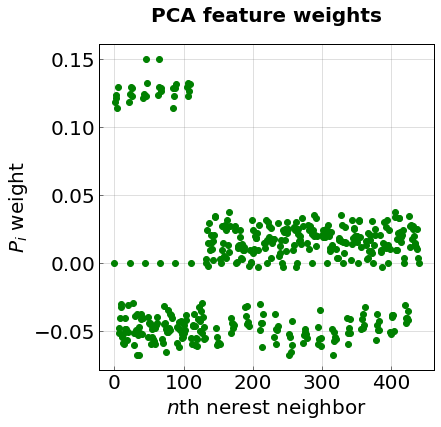

In [23]:
#highlight the transition region if found
#plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
#plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plt.axvspan(0.716, 0.716001, alpha=1, color='black')
#plt.axvspan(0.781, 0.781001, alpha=1, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1):
    p_data = incpca.components_[i]
    plt.plot(range(len(incpca.components_[0])), p_data, marker='o', linewidth = 0.0, markersize=6, color = colors[i])
    #p_data = OPs_non_abs[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 2.0, markersize=10, color = colors[i])
#plt.plot(etas, num_defects, marker='o', linewidth = 2.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0,103)
#plt.ylim(-1,0)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.xscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

In [26]:
OPs = []
frames = None
features = None
raw_OPs = []

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True)[0::400]
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        raw_OPs_single = []
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeaturesComposition(frames_partial, probe_particle_indicies=probe_particle_indicies)
            transformed_features_partial = incpca.transform(features_partial)
            means.append(mean(transformed_features_partial, axis=0))
            raw_OPs_single.append(transformed_features_partial)
            count = count + 1
            print count
            
        means = array(means)
        op = mean(means, axis=0)
        OPs.append(op)
        raw_OPs.append(raw_OPs_single)
    
OPs = array(OPs)        

eta=0.1

1
eta=0.14

1
eta=0.18

1
eta=0.22

1
eta=0.26

1
eta=0.3

1
eta=0.34

1
eta=0.38

1
eta=0.42

1
eta=0.46

1
eta=0.5

1
eta=0.54

1
eta=0.58

1
eta=0.62

1
eta=0.66

1
eta=0.7

1
eta=0.74

1
eta=0.78

1
eta=0.82

1
eta=0.86

1
eta=0.9

1
eta=0.94

1
eta=0.98

1
eta=1.02

1
eta=1.06

1
eta=1.1

1
eta=1.14

1
eta=1.18

1
eta=1.22

1
eta=1.26

1
eta=1.3

1
eta=1.34

1
eta=1.38

1
eta=1.42

1
eta=1.46

1
eta=1.5

1
eta=1.54

1
eta=1.58

1
eta=1.62

1
eta=1.66

1
eta=1.7

1
eta=1.74

1
eta=1.78

1
eta=1.82

1
eta=1.86

1
eta=1.9

1
eta=1.94

1
eta=1.98

1
eta=2.02

1
eta=2.06

1
eta=2.1

1
eta=2.14

1
eta=2.18

1
eta=2.22

1
eta=2.26

1
eta=2.3

1
eta=2.34

1
eta=2.38

1
eta=2.42

1
eta=2.46

1
eta=2.5

1
eta=2.54

1
eta=2.58

1
eta=2.62

1
eta=2.66

1
eta=2.7

1
eta=2.74

1
eta=2.78

1
eta=2.82

1
eta=2.86

1
eta=2.9

1
eta=2.94

1
eta=2.98

1
eta=3.02

1
eta=3.06

1
eta=3.1

1
eta=3.14

1
eta=3.18

1
eta=3.22

1
eta=3.26

1
eta=3.3

1
eta=3.34

1
eta=3.38

1
eta=3.42

1
eta=3.46


In [39]:
from numpy import std, abs, power
from scipy.stats import moment

OPs = []
OPs_std = []
OPs_abs = []
OPs_third = []
for single_eta in raw_OPs:
    merged_data = []
    for split in single_eta:
        merged_data.extend(split)
    
    OPs.append(mean((split), axis=0))
    OPs_std.append(std(split, axis=0))
    OPs_abs.append(mean(abs(split), axis=0))
    OPs_third.append(moment(split, 4, axis=0))

OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)
OPs_third = array(OPs_third)

In [28]:
OPs = []
OPs_std = []
OPs_abs = []

for single_eta in raw_OPs:
    merged_data = []
    for split in single_eta:
        merged_data.extend(split)

    OPs.append(mean(merged_data, axis=0))
    OPs_std.append(std(merged_data, axis=0))
    OPs_abs.append(mean(abs(merged_data), axis=0))
    
OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


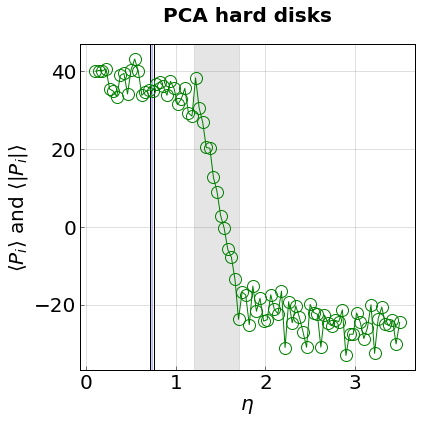

In [36]:
#highlight the transition region if found
plt.axvspan(1.2, 1.7, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

plt.axvspan(0.716, 0.716001, alpha=1, color='black')
plt.axvspan(0.76, 0.76001, alpha=1, color='black')

#plt.axvspan(0.72, 0.72001, alpha=10, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = OPs_abs[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)

#plt.xlim(0.10, 2.1)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

### Old stuff

In [314]:
a = array([[1,1,1],[2,2,2],[3,3,3],[4,4,4]])
b = array([1,1,1])

In [315]:
a - b

array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

## 3D hard spheres

In [65]:
from numpy import mean, array, unique, concatenate, power, std
from numpy.random import shuffle, rand
from copy import deepcopy
import re

def ReadXYZ(filename, N, N_types, shuffle_data=True, randomize=False):
    #regex used to parse the data
    xyz_regex = r'(?:([a-zA-Z]+)\s+([0-9\.e\-\+]+)\s+([0-9\.e\-\+]+)\s+([0-9\.e\-\+]+)\s+([0-9\.e\-\+]+))'
    L_regex = r'(?:L\s*=\s*([0-9\.e\-\+]+))'
    
    #read in the data and check for volume fraction consistency
    eta_stats = []
    with open(filename, "r") as ins:
        frames = [] #xyz and diameter
        coords, coords_count = [], 0
        diameters = []
        types = []
        L = None
        for line in ins:
            search = re.search(xyz_regex, line)
            if search and coords_count < N:
                coords.append(array([float(search.group(2)), float(search.group(3)), float(search.group(4))]))
                diameters.append(2.0*float(search.group(5)))
                types.append(search.group(1))
                coords_count = coords_count + 1
            elif coords:
                coords = array(coords)
                diameters = array(diameters)
                types = array(types)
                sorter = diameters.argsort()
                coords = coords[sorter]
                diameters = diameters[sorter]
                types = types[sorter]
                #replace with random positions if randomize is selected (for comparing to randomized PCA result and useful information content)
                if randomize:
                    coords = L*rand(len(coords), len(coords[0]))
                frames.append({'coords': array(coords), 'diameters': array(diameters), 'types': array(types), 'L': L, 'D': len(coords[0])})
                eta_stats.append(sum(power(diameters, 3.0))/power(L, 3.0))
                coords, coords_count = [], 0
                diameters = []
                types = []
                L = None
                search_L = re.search(L_regex, line)
                if search_L:
                    L = float(search_L.group(1))
            else:
                search_L = re.search(L_regex, line)
                if search_L:
                    L = float(search_L.group(1))
                    
        #append final frame
        coords = array(coords)
        diameters = array(diameters)
        types = array(types)
        sorter = diameters.argsort()
        coords = coords[sorter]
        diameters = diameters[sorter]
        types = types[sorter]
        #replace with random positions if randomize is selected (for comparing to randomized PCA result and useful information content)
        if randomize:
            coords = L*rand(len(coords), len(coords[0]))
        frames.append({'coords': array(coords), 'diameters': array(diameters), 'types': array(types), 'L': L, 'D': len(coords[0])})
        eta_stats.append(sum(power(diameters, 3.0))/power(L, 3.0))
        
    #check that the volume fraction is consistent accross all frames
    if std(eta_stats)/mean(eta_stats) > 0.0000001:
        raise Exception('Volume fractions seem inconsistent accross frames!!!')
        
    #perform random shuffle of identical particles coordinates to help facilitate learning    
    if shuffle_data:
        shuffled_frames = []
        for frame in frames:
            #extract local copies for organizational convenience
            coords = frame['coords']
            diameters = frame['diameters']
            types = frame['types']
            L = frame['L']
            
            #prepare for shuffle
            coords_shuffled = None
            unique_types, start, count = unique(types, return_index=True, return_inverse=False, return_counts=True, axis=None)
            start__end = zip(start, start+count)
            #print types
            
            #check for errors
            if len(start__end) != len(unique_types):
                raise Exception('Bad data!!!')
            
            #do the shuffling
            for start, end in start__end:
                grouped = deepcopy(coords[start:end])
                shuffle(grouped)
                if coords_shuffled is not None:
                    coords_shuffled = concatenate((coords_shuffled, grouped), axis=0)
                else:
                    coords_shuffled = deepcopy(grouped)
            shuffled_frames.append({'coords': array(coords_shuffled), 'diameters': array(diameters), 'types': array(types), 'L': L, 'D': len(coords_shuffled[0])})
        
        #set the data
        frames = shuffled_frames
        shuffled_frames = []
        
        
    #perform a check that everything was read in and/or processed correctly
    for frame in frames:
        if len(frame['coords']) != N or len(frame['diameters']) != N or frame['L'] is None or len(set(types)) != N_types:
            raise Exception('Bad data!!!')
        else:
            continue
    
    return frames

In [121]:
N_nn = 300 #5000 #number of nearest nighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
particle_inc = 50 #skip this many particles in generating features
nn_inc = 1  #reduces the number of nearest neighbors to include as features
method = ['distance']

In [119]:
#specify what data to read in and process
file_data = [(range(1,51), '/home/ryanj/Documents/research_projects/polydisperse_simulations/fluid_only/300p_sims/inc_mono')]

In [638]:
frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=True)

In [126]:
filename = '/home/ryanj/Documents/research_projects/polydisperse_simulations/fluid_only/300p_sims/inc_mono/step_50/trajectory.xyz'
frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=True)

In [639]:
frames_nr = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=False)

In [120]:
etas=arange(0.4, 0.645001, 0.005)

In [122]:
n_components_ig = 299 #96  #for this the more the better, however, 50 is probably enough

In [123]:
randomize = True
incpca_ig = IncrementalPCA(n_components=n_components_ig, whiten=True)

frames = None
features = None
split_features = None

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/step_{}/trajectory.xyz".format(file_base, eta)
        frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            incpca_ig.partial_fit(features_partial)
            count = count + 1
            print count
        frames_split = None

eta=1
1
eta=2
1
eta=3
1
eta=4
1
eta=5
1
eta=6
1
eta=7
1
eta=8
1
eta=9
1
eta=10
1
eta=11
1
eta=12
1
eta=13
1
eta=14
1
eta=15
1
eta=16
1
eta=17
1
eta=18
1
eta=19
1
eta=20
1
eta=21
1
eta=22
1
eta=23
1
eta=24
1
eta=25
1
eta=26
1
eta=27
1
eta=28
1
eta=29
1
eta=30
1
eta=31
1
eta=32
1
eta=33
1
eta=34
1
eta=35
1
eta=36
1
eta=37
1
eta=38
1
eta=39
1
eta=40
1
eta=41
1
eta=42
1
eta=43
1
eta=44
1
eta=45
1
eta=46
1
eta=47
1
eta=48
1
eta=49
1
eta=50
1


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if __name__ == '__main__':


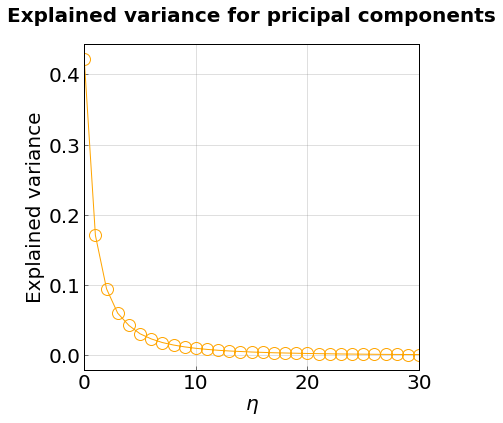

In [124]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca_ig.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'orange', markerfacecolor='None')  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
plt.xlim(0,30)

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Explained variance for pricipal components', y=1.05, fontdict = title_font)

plt.show()

In [126]:
sum(incpca_ig.explained_variance_ratio_[0:299])

0.99999999990145572

In [109]:
n_components = 299 #96 #this number will not affect the quality of the result just the computation time and amount of info returned
n_ig = 50# 20

In [127]:
randomize = False
incpca = IncrementalPCA(n_components=n_components_ig , whiten=False)

frames = None
features = None
split_features = None

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/step_{}/trajectory.xyz".format(file_base, eta)
        frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            #features_partial_ig_projection = incpca_ig.inverse_transform(incpca_ig.transform(features_partial))
            #incpca.partial_fit(features_partial - features_partial_ig_projection)
            incpca.partial_fit(incpca_ig.transform(features_partial))
            
            count = count + 1
            print count
        frames_split = None

eta=1
1
eta=2
1
eta=3
1
eta=4
1
eta=5
1
eta=6
1
eta=7
1
eta=8
1
eta=9
1
eta=10
1
eta=11
1
eta=12
1
eta=13
1
eta=14
1
eta=15
1
eta=16
1
eta=17
1
eta=18
1
eta=19
1
eta=20
1
eta=21
1
eta=22
1
eta=23
1
eta=24
1
eta=25
1
eta=26
1
eta=27
1
eta=28
1
eta=29
1
eta=30
1
eta=31
1
eta=32
1
eta=33
1
eta=34
1
eta=35
1
eta=36
1
eta=37
1
eta=38
1
eta=39
1
eta=40
1
eta=41
1
eta=42
1
eta=43
1
eta=44
1
eta=45
1
eta=46
1
eta=47
1
eta=48
1
eta=49
1
eta=50
1


In [131]:
frames = None
features = None
raw_OPs = []

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/step_{}/trajectory.xyz".format(file_base, eta)
        frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        raw_OPs_single = []
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            #features_partial_ig_projection = incpca_ig.inverse_transform(incpca_ig.transform(features_partial))
            #transformed_features_partial = incpca.transform(features_partial - features_partial_ig_projection)
            #raw_OPs_single.append(transformed_features_partial)
            transformed_features_partial = incpca.transform(incpca_ig.transform(features_partial))
            raw_OPs_single.append(transformed_features_partial)
            count = count + 1
            print count
            
        raw_OPs.append(raw_OPs_single)  

eta=1
1
eta=2
1
eta=3
1
eta=4
1
eta=5
1
eta=6
1
eta=7
1
eta=8
1
eta=9
1
eta=10
1
eta=11
1
eta=12
1
eta=13
1
eta=14
1
eta=15
1
eta=16
1
eta=17
1
eta=18
1
eta=19
1
eta=20
1
eta=21
1
eta=22
1
eta=23
1
eta=24
1
eta=25
1
eta=26
1
eta=27
1
eta=28
1
eta=29
1
eta=30
1
eta=31
1
eta=32
1
eta=33
1
eta=34
1
eta=35
1
eta=36
1
eta=37
1
eta=38
1
eta=39
1
eta=40
1
eta=41
1
eta=42
1
eta=43
1
eta=44
1
eta=45
1
eta=46
1
eta=47
1
eta=48
1
eta=49
1
eta=50
1


In [132]:
OPs = []
OPs_std = []
OPs_abs = []

i = 0
for single_eta in raw_OPs:
    print i
    merged_data = []
    for split_ in single_eta:
        merged_data.extend(split_)
    
    #OPs.append(mean((split), axis=0))
    #OPs_std.append(std(split, axis=0))
    #OPs_abs.append(mean(abs(split), axis=0))

    OPs.append(mean(merged_data, axis=0))
    OPs_std.append(std(merged_data, axis=0))
    OPs_abs.append(mean(abs(merged_data), axis=0))
    i = i + 1
    
OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


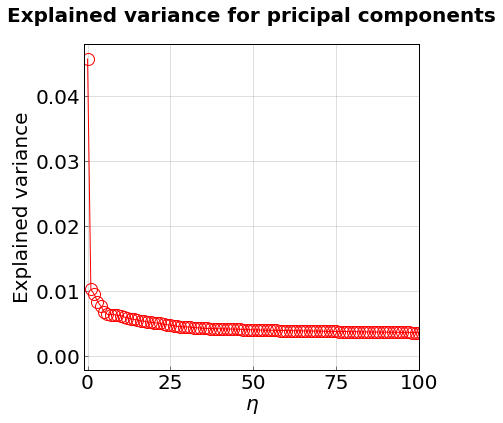

In [133]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'red', markerfacecolor='None')  
#plt.plot(incpca_ig.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=5, color = 'orange', markerfacecolor='None')  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.xscale('log')
#plt.ylim(0.0,0.2)
plt.xlim(-1,100)
#plt.yscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Explained variance for pricipal components', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  app.launch_new_instance()


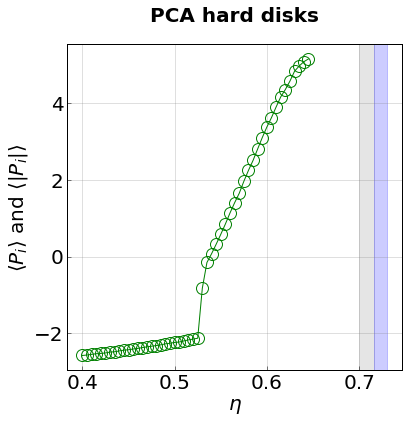

In [143]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = OPs_abs[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


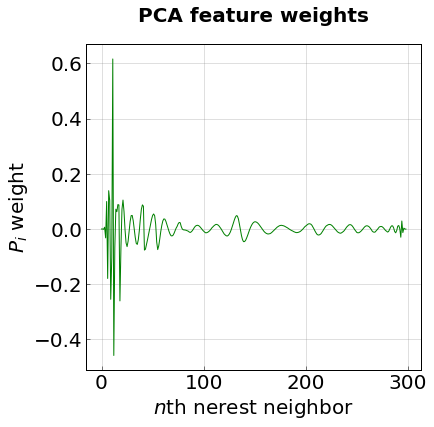

In [115]:
#plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
#plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plt.axvspan(0.716, 0.716001, alpha=1, color='black')
#plt.axvspan(0.781, 0.781001, alpha=1, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1):
    p_data = incpca_ig.components_[i]
    #plt.plot(range(len(incpca_ig.components_[0])), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i]) 
    p_data = incpca.components_[i]
    plt.plot(range(len(incpca.components_[0])), p_data, marker='o', linewidth = 1.0, markersize=0, color = colors[i])  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.1,100)
#plt.ylim(-0.001,0.001)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.xscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

In [148]:
filename = '/home/ryanj/Documents/research_projects/polydisperse_simulations/fluid_only/300p_sims/inc_mono/step_20/trajectory.xyz'
frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=False)

KeyboardInterrupt: 

In [140]:
r, gr = RDF(frames[0::100], 0.01)

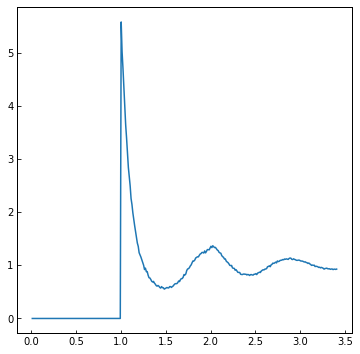

In [141]:
plt.plot(r[1:],gr[1:])
#plt.ylim(0,5)

In [149]:
dr = 0.01
skip_frames = 100
pos_spts = []

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/step_{}/trajectory.xyz".format(file_base, eta)
        frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=randomize)
        pos_spt, _, _ = PositionalSuceptibility2D(frames[0::skip_frames], dr=dr)
        pos_spts.append(pos_spt)

eta=1
eta=2
eta=3
eta=4
eta=5
eta=6
eta=7
eta=8
eta=9
eta=10
eta=11
eta=12
eta=13
eta=14
eta=15
eta=16
eta=17
eta=18
eta=19
eta=20
eta=21
eta=22
eta=23
eta=24
eta=25
eta=26
eta=27
eta=28
eta=29
eta=30
eta=31
eta=32
eta=33
eta=34
eta=35
eta=36
eta=37
eta=38
eta=39
eta=40
eta=41
eta=42
eta=43
eta=44
eta=45
eta=46
eta=47
eta=48
eta=49
eta=50


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # This is added back by InteractiveShellApp.init_path()


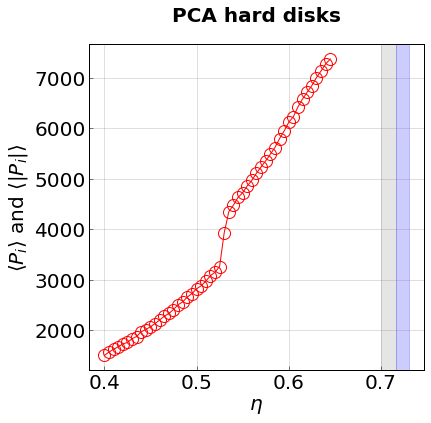

In [151]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plot the principal components
plt.plot(etas, pos_spts, marker='o', linewidth = 1.0, markersize=12, color = 'red', markerfacecolor='None')

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

In [157]:
n = 64
float(len(range(n*n/4, n*n)))/float(len(range(0, n*n)))

0.75

In [161]:
arange(0.1, 3.50001, 0.04)

array([ 0.1 ,  0.14,  0.18,  0.22,  0.26,  0.3 ,  0.34,  0.38,  0.42,
        0.46,  0.5 ,  0.54,  0.58,  0.62,  0.66,  0.7 ,  0.74,  0.78,
        0.82,  0.86,  0.9 ,  0.94,  0.98,  1.02,  1.06,  1.1 ,  1.14,
        1.18,  1.22,  1.26,  1.3 ,  1.34,  1.38,  1.42,  1.46,  1.5 ,
        1.54,  1.58,  1.62,  1.66,  1.7 ,  1.74,  1.78,  1.82,  1.86,
        1.9 ,  1.94,  1.98,  2.02,  2.06,  2.1 ,  2.14,  2.18,  2.22,
        2.26,  2.3 ,  2.34,  2.38,  2.42,  2.46,  2.5 ,  2.54,  2.58,
        2.62,  2.66,  2.7 ,  2.74,  2.78,  2.82,  2.86,  2.9 ,  2.94,
        2.98,  3.02,  3.06,  3.1 ,  3.14,  3.18,  3.22,  3.26,  3.3 ,
        3.34,  3.38,  3.42,  3.46,  3.5 ])

# Analyze single trajectory and identify regions

In [259]:
filename = '/home/ryanj/Documents/hoomd-examples/hoomd_spheres/trajectories_4000p/trajectory_0.6200.gsd'

In [288]:
N_nn = 500 #5000 #number of nearest nighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
particle_inc = 10 #skip this many particles in generating features
nn_inc = 1  #reduces the number of nearest neighbors to include as features
method = ['distance']

In [289]:
n_components_single = 499

In [290]:
#frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=True)
frames = ReadGSD(filename, shuffle_data=True, randomize=True, remove_types=[])[:100]
features = TrajectoryToFeatures(frames, 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=particle_inc, 
                                nn_inc=nn_inc)
incpca_single_ig = IncrementalPCA(n_components=n_components_single, whiten=True)
incpca_single_ig.partial_fit(features)

IncrementalPCA(batch_size=None, copy=True, n_components=499, whiten=True)

In [291]:
#frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=False)
frames = ReadGSD(filename, shuffle_data=True, randomize=False, remove_types=[])[:100]
features = TrajectoryToFeatures(frames, 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=particle_inc, 
                                nn_inc=nn_inc)
incpca_single = IncrementalPCA(n_components=n_components_single, whiten=False)
incpca_single.partial_fit(incpca_single_ig.transform(features))

IncrementalPCA(batch_size=None, copy=True, n_components=499, whiten=False)

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


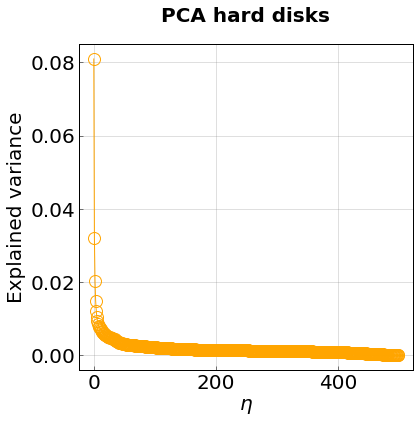

In [299]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#plt.plot(incpca_single_ig.explained_variance_ratio_, marker='o', linewidth = 1.0, markersize=12, color = 'red', markerfacecolor='None')
plt.plot(incpca_single.explained_variance_ratio_, marker='o', linewidth = 1.0, markersize=12, color = 'orange', markerfacecolor='None')
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.ylim(0.001,1.0)
#plt.yscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


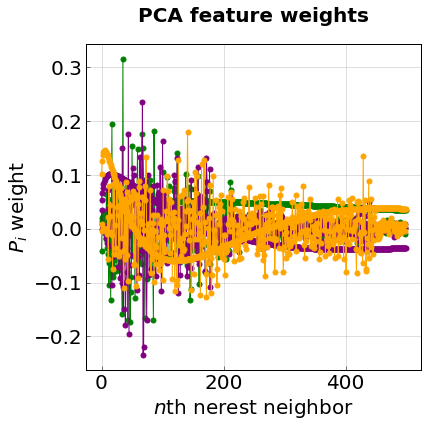

In [297]:
#plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
#plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plt.axvspan(0.716, 0.716001, alpha=1, color='black')
#plt.axvspan(0.781, 0.781001, alpha=1, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,3):
    p_data = incpca_single_ig.components_[i]
    plt.plot(range(len(incpca_single_ig.components_[0])), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i])  
    p_data = incpca_single.components_[i]
    plt.plot(range(len(incpca_single.components_[0])), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i])  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.1,100)
#plt.ylim(-0.001,0.001)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.xscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

In [75]:
pc = 0
xyz_file_stream = open('op_labeled/hs_P{}.xyz'.format(pc), 'w')
for frame in frames[0:40]:
    coords = frame['coords']
    N = len(coords)
    L = frame['L']
    types = frame['types']
    
    #transform the data to features
    ops = incpca_single.transform(incpca_single_ig.transform(features))[:,pc]
    
    #create header
    xyz_file_stream.write('{}\n'.format(N))
    xyz_file_stream.write(' L={}\n'.format(L))
    
    #joint data
    coords_ops_types = zip(coords, ops, types)
    for coord, op, type_ in coords_ops_types:
        xyz_file_stream.write('  {}    {}    {}    {}    {}\n'.format(type_, coord[0], coord[1], coord[2], op))
xyz_file_stream.close()
                                 

KeyboardInterrupt: 

In [ ]:
frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=True)
features = TrajectoryToFeatures(frames, 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=particle_inc, 
                                nn_inc=nn_inc)
incpca_single_ig = IncrementalPCA(n_components=n_components_single, whiten=False)
incpca_single_ig.partial_fit(features)

frames = None

frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=True, randomize=False)
features = TrajectoryToFeatures(frames, 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=particle_inc, 
                                nn_inc=nn_inc)
incpca_single_ig = IncrementalPCA(n_components=n_components_single, whiten=False)
incpca_single_ig.partial_fit(features)

In [127]:
pcs = 

10000

In [ ]:
plt.plot()

In [295]:
#frames = ReadXYZ(filename, N=300, N_types=1, shuffle_data=False, randomize=False)
#frames = ReadGSD(filename, shuffle_data=True, randomize=False, remove_types=[])[:100]
features = TrajectoryToFeatures(frames[::10], 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=1, 
                                nn_inc=1)
pcs = incpca_single.transform(incpca_single_ig.transform(features))

In [274]:
pcs_avg = 0.0
count = 0.0
for frame in frames[0::10]:
    if int(count) % 100 == 0:
        print count
    features = TrajectoryToFeatures([frame], 
                                N_nn=N_nn, 
                                method=method, 
                                particle_inc=1, 
                                nn_inc=1)
    pcs_avg = pcs_avg + incpca_single.transform(incpca_single_ig.transform(features))
    count  =  count + 1.0
pcs_avg = pcs_avg / count    

0.0


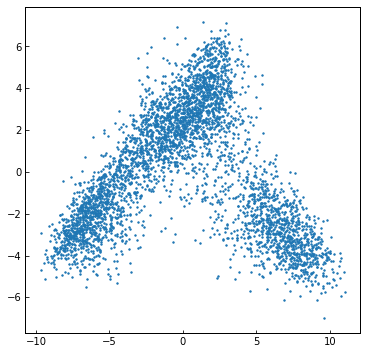

In [273]:
plt.scatter(pcs_avg[:,0][0::1], pcs_avg[:,1][0::1], s=2)
plt.rcParams["figure.figsize"] = [6,6]

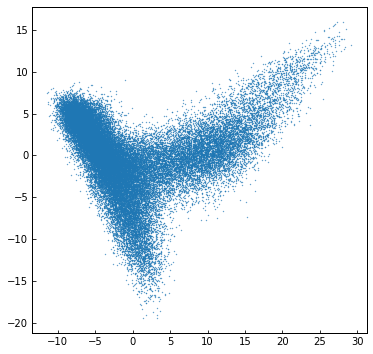

In [300]:
plt.scatter(pcs[:,0][0::1], pcs[:,1][0::1], s=0.1)
plt.rcParams["figure.figsize"] = [6,6]

In [111]:
len(pcs)

300

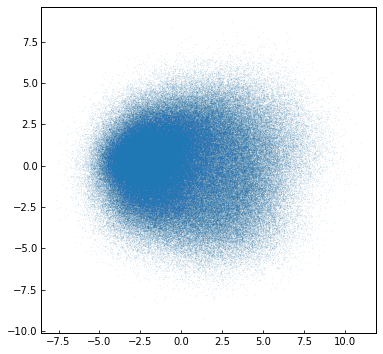

In [91]:
plt.scatter(pcs[:,1][0::1], pcs[:,2][0::1], s=0.001)
plt.rcParams["figure.figsize"] = [6,6]

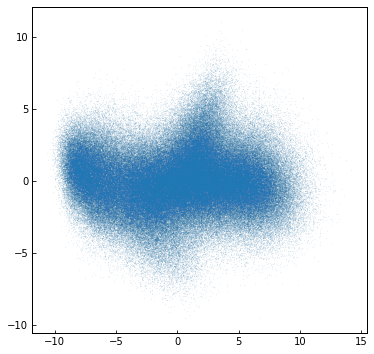

In [82]:
plt.scatter(pcs[:,0][0::1], pcs[:,3][0::1], s=0.001)
plt.rcParams["figure.figsize"] = [6,6]

In [43]:
1023/116

8

In [45]:
116*8

928

In [95]:
a = array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
#a = array([1,2,3,4,5])

In [96]:
from numpy import append

In [99]:
samples = 3

In [100]:
a[0::len(a)/samples+1][0:samples]

array([ 1,  7, 13])

In [45]:
from numpy import unique

In [46]:
types = array(['A','A','B','A','B','A','B','B','B'])

In [51]:
unique_types, start, count = unique(types, return_index=True, return_inverse=False, return_counts=True, axis=None)
start__end = zip(start, start+count)

In [52]:
start__end

[(0, 4), (2, 7)]

In [50]:
count

array([4, 5])

In [ ]:
coords_shuffled = None
unique_types, start, count = unique(types, return_index=True, return_inverse=False, return_counts=True, axis=None)
start__end = zip(start, start+count)

In [ ]:
encountered = set([])
last_type = None
for entry in types:
    if entry != last_type:
        if last_type in encountered:
            raise error
        else:
            encountered
        
    if entry in encountered:
        
        
    

In [ ]:
#this generates NN features for the PCA analysis (or some other machine learning method as well)
def FrameToFeaturesMultiParticle(frame, N_nn, nn_inc, probe_particle_indicies):
    #extract some relevant frames level details
    coords = deepcopy(frame['coords'])
    D = float(frame['D'])
    N = float(len(coords))
    V = power(frame['L'], D)
    normalizing_distance = power(V/N, 1.0/D)
    
    frame_features = []
    for particle in coords[probe_particle_indicies]:
        #nearest neighbor coordinate wrapping
        Rpj_v = particle - coords
        Rpj_v = Rpj_v - rint(Rpj_v/frame['L'])*frame['L']
        Rpj = (sqrt(sum(power(Rpj_v, 2.0), axis=1)))     
        
        #generate statistics for various nearest neighbors
        sorter = Rpj.argsort()
        Rpj = Rpj[sorter[::1]]
        
        #create features that correspond to probe particles and their nearest neighbors
        frame_features.append((Rpj[1:N_nn+1])[0::nn_inc])
        frame_features = sorted(frame_features)

    return array(frame_features).flatten()

#this converts an entire trajectory into features
def TrajectoryToFeaturesMultiParticle(frames, N_nn, nn_inc, probe_particle_indicies):
    #print filename
    features = []
    for frame in frames:        
        features_sp = FrameToFeaturesMultiParticle(frame, N_nn, method, particle_inc, nn_inc)
        for feature in features_sp:
            features.append(feature)
    return features

In [27]:
sorted([[1,2,3,4],[2,3,1,0],[1,1,1,4],[3,0,2,2]])

[[1, 1, 1, 4], [1, 2, 3, 4], [2, 3, 1, 0], [3, 0, 2, 2]]

In [26]:
a

In [ ]:
    #this converts an entire trajectory into features
    def TrajectoryToFeaturesMultiParticle(frames, N_nn, nn_inc, probe_particle_indicies):
        #print filename
        features = []
        for frame in frames:        
            features_sp = FrameToFeaturesMultiParticle(frame, N_nn, method, particle_inc, nn_inc)
            for feature in features_sp:
                features.append(feature)
        return features

In [24]:
from random import uniform, randint
from copy import deepcopy

class ReservoirSampler:
    
    def __init__(self, max_samples):
        self.max_samples = max_samples
        self.num_samples = 0
        #self.reservoir = dict.fromkeys(range(1, self.max_samples+1))
        self.reservoir = []
    
    def NewSamples(self, samples):
        for sample in samples:
            self.num_samples+=1
            if self.num_samples <= self.max_samples:
                self.reservoir.append(deepcopy(sample))
            else:
                prob_add = float(self.max_samples) / float(self.num_samples)
                if uniform(0,1) <= prob_add:
                    self.reservoir.pop(randint(0,self.max_samples-1))
                    self.reservoir.append(deepcopy(sample))
    
    def ReturnReservoir(self):
        return self.reservoir

In [48]:
batch_1 = [[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]
batch_2 = [[1.0,2.0],[2.0,3.0],[3.0,4.0],[4.0,5.0],[5.0,6.0],[6.0,7.0],[7.0,8.0],[8.0,9.0]]

In [49]:
reservoir_sampler = ReservoirSampler(5)

In [50]:
reservoir_sampler.NewSamples(batch_1)
reservoir_sampler.NewSamples(batch_2)
reservoir_sampler.NewSamples(batch_2)
reservoir_sampler.NewSamples(batch_1)

In [51]:
reservoir_sampler.ReturnReservoir()

[[5, 6], [1.0, 2.0], [1.0, 2.0], [3.0, 4.0], [7.0, 8.0]]

In [121]:
reservoir_sampler.reservoir

{1: [2.0, 3.0], 2: [6.0, 7.0], 3: [3, 4], 4: [4, 5], 5: [4.0, 5.0]}

In [53]:
reservoir_sampler.reservoir

[[6, 7], [7, 8], [5.0, 6.0], [1, 2], [3, 4]]

In [52]:
import time
for i in range(1000):
    reservoir_sampler.NewSamples(batch_1)
    reservoir_sampler.NewSamples(batch_2)
    print i
    #time.sleep(2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
size(reservoir_sampler.reservoir)

NameError: name 'size' is not defined

In [47]:
from sys import getsizeof
from numpy import log

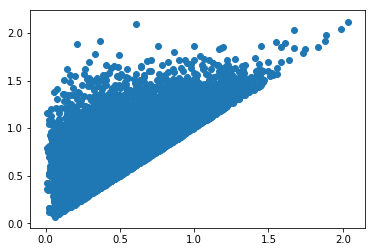

In [38]:
pi=0
pj=1
Pi=(array(reservoir_sampler.ReturnReservoir()))
Pj=(array(reservoir_sampler.ReturnReservoir()))
plt.scatter(Pi[:,pi],Pj[:,pj])